In [80]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [81]:
# Load datasets
sp500_train = pd.read_csv('Datasets/sp500_train.csv', index_col='Date', parse_dates=True)
sp500_test = pd.read_csv('Datasets/sp500_test.csv', index_col='Date', parse_dates=True)
tesla_train = pd.read_csv('Datasets/tesla_train.csv', index_col='Date', parse_dates=True)
tesla_test = pd.read_csv('Datasets/tesla_test.csv', index_col='Date', parse_dates=True)

In [82]:
#LSTM model - SP500

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
sp500_train_scaled = scaler.fit_transform(sp500_train)
sp500_test_scaled = scaler.transform(sp500_test)

# Sequence
time_steps = 4
train_generator_sp500 = TimeseriesGenerator(sp500_train_scaled, sp500_train_scaled, length=time_steps, batch_size=32)
test_generator_sp500 = TimeseriesGenerator(sp500_test_scaled, sp500_test_scaled, length=time_steps, batch_size=32)

#Building the LSTM model
model_sp500 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.3),
    LSTM(30, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1),
    ])

model_sp500.compile(optimizer='adam', loss='mean_squared_error')

model_sp500.summary()

model_sp500.fit(train_generator_sp500, epochs=20, validation_data=test_generator_sp500)

prediction_sp500 = model_sp500.predict(test_generator_sp500)



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 4, 50)             10400     
                                                                 
 dropout_34 (Dropout)        (None, 4, 50)             0         
                                                                 
 lstm_35 (LSTM)              (None, 30)                9720      
                                                                 
 dropout_35 (Dropout)        (None, 30)                0         
                                                                 
 dense_34 (Dense)            (None, 25)                775       
                                                                 
 dense_35 (Dense)            (None, 1)                 26        
                                                                 
Total params: 20,921
Trainable params: 20,921
Non-tra

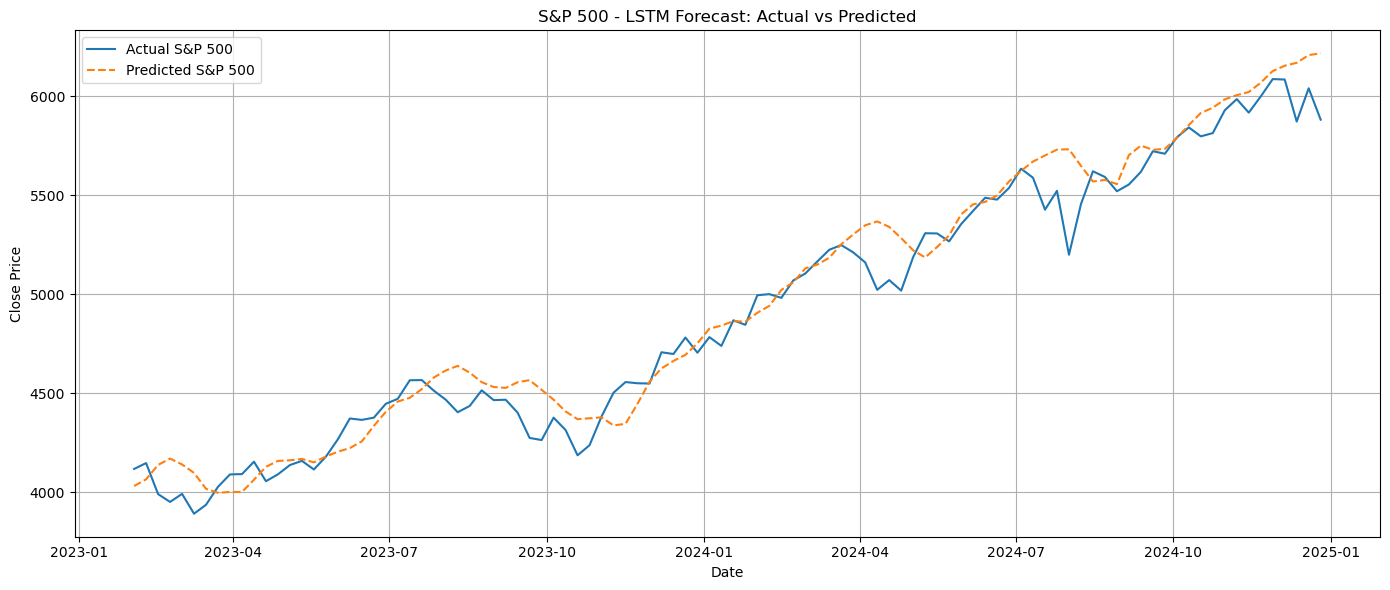

In [83]:
# Reconstruct the actual test values aligned with the predictions
actual_sp500 = sp500_test.iloc[time_steps:].copy()
actual_sp500 = actual_sp500[:len(prediction_sp500)]  # Match lengths

# Inverse transform the predictions back to original scale
prediction_sp500_unscaled = scaler.inverse_transform(prediction_sp500)
actual_sp500_unscaled = scaler.inverse_transform(sp500_test_scaled[time_steps:])  # Original scaled test values

# Build a dataframe for comparison
results_sp500 = pd.DataFrame({
    'Date': actual_sp500.index,
    'Actual': actual_sp500_unscaled.flatten(),
    'Predicted': prediction_sp500_unscaled.flatten()
})
results_sp500.set_index('Date', inplace=True)

# Plot the actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(results_sp500['Actual'], label='Actual S&P 500')
plt.plot(results_sp500['Predicted'], label='Predicted S&P 500', linestyle='--')
plt.title('S&P 500 - LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
RMSE_sp500 = mean_squared_error(results_sp500['Actual'], results_sp500['Predicted'])